# Shared marmo models

In [1]:
# Import the rest
from __future__ import print_function
from __future__ import division

import sys

# sys.path.insert(0, '/home/dbutts/Code/')
sys.path.insert(0, 'C:\\Users\\Jake\\Documents\\')
sys.path.insert(0, 'C:\\Users\\Jake\\Documents\\NDN3')

import NDN3.NDNutils as NDNutils
# which_gpu = NDNutils.assign_gpu()
#NDNutils.setup_no_gpu()


import os
import h5py
import numpy as np
import tensorflow as tf
import scipy.io as sio           # importing matlab data
import matplotlib.pyplot as plt  # plotting
%matplotlib inline
from copy import deepcopy

import time
import random
import NDN3.NDN as NDN
#import TNDN as TNDN
import NDN3.Utils.DanUtils as DU
import NDN3.Utils.NDNplot as NDNplot
output_dir = 'C:\\Users\\Jake\\Dropbox\\Projects\\NDN\\output_dir'
# output_dir = '/Users/dbutts/Code/PyPlay/tensorboard'
print(sys.version)
import sys
print(sys.path)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(1)

print(output_dir)

3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
['C:\\Users\\Jake\\Documents\\NDN3', 'C:\\Users\\Jake\\Documents\\', 'C:\\Users\\Jake\\.conda\\envs\\NDN\\python36.zip', 'C:\\Users\\Jake\\.conda\\envs\\NDN\\DLLs', 'C:\\Users\\Jake\\.conda\\envs\\NDN\\lib', 'C:\\Users\\Jake\\.conda\\envs\\NDN', '', 'C:\\Users\\Jake\\.conda\\envs\\NDN\\lib\\site-packages', 'C:\\Users\\Jake\\.conda\\envs\\NDN\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Jake\\.ipython']
C:\Users\Jake\Dropbox\Projects\NDN\output_dir


In [7]:
dirname = '/home/dbutts/Marmo/'
os.chdir(dirname)
matdat=sio.loadmat('Data/L20200303_Gabor.mat')
#stim1 = matdat['stim'].copy()
Robs1 = matdat['Robs'].copy()
valdat1 = matdat['valdata'].copy()
labels1 = matdat['labels'].copy()
valid1 = np.intersect1d(np.where(valdat1[:,0] == 1)[0], np.where(labels1[:,0] == 1)[0])
slist1 = matdat['slist'].astype(int)
dt = matdat['dt'][0][0]
NY = matdat['NX'][0][0].astype(int)
NP = stim1.shape[1]
ets1 = matdat['eyeAtFrame']
NX = (NP//NY).astype(int)
NT1,NCfull = Robs1.shape
# Overwrite with corrected stimulus
matdat=sio.loadmat('Data/L20191231_Gabor_Cstim.mat')
stim1 = matdat['Cstim'].copy()

matdat = sio.loadmat('Data/L20191231_GratingL.mat')
#stim2 = matdat['stim'].copy()
Robs2 = matdat['Robs'].copy()
valdat2 = matdat['valdata'].copy()
labels2 = matdat['labels'].copy()
valid2 = np.intersect1d(np.where(valdat2[:,0] == 1)[0], np.where(labels2[:,0] == 1)[0])
slist2 = matdat['slist'].astype(int)
ets2 = matdat['eyeAtFrame']
NT2 = Robs2.shape[0]
print(NT1, NT2, NCfull,'|', NX, NY)
# Overwrite with corrected stimulus
matdat=sio.loadmat('Data/L20191231_Grating_Cstim.mat')
stim2 = matdat['Cstim'].copy()


#matdat = sio.loadmat('Data/L20191231_BackImageL.mat')
#stim3 = matdat['stim'].copy()
#Robs3 = matdat['Robs'].copy()
#valdat3 = matdat['valdata'].copy()
#labels3 = matdat['labels'].copy()
#valid3 = np.intersect1d(np.where(valdat3[:,0] == 1)[0], np.where(labels3[:,0] == 1)[0])
#slist3 = matdat['slist'].astype(int)
#ets3 = matdat['eyeAtFrame']
#NT3 = Robs3.shape[0]
#print(NT1, NT2, NT3, '|', NCfull, '|', NX, NY)

96984 77295 61 | 40 40


In [8]:
# Determine valid indices based on eye position
valid_eye_rad = 5.0  # degrees
pixPerDeg = 37.50476617061
# Radial eye position (in degrees)
er1s = np.divide(np.sqrt(np.add(np.square(ets1[:,0]-640), np.square(ets1[:,1]-360))), pixPerDeg)
er2s = np.divide(np.sqrt(np.add(np.square(ets2[:,0]-640), np.square(ets2[:,1]-360))), pixPerDeg)
#er3s = np.divide(np.sqrt(np.add(np.square(ets3[:,0]-640), np.square(ets3[:,1]-360))), pixPerDeg)

# Selection of valid indices where eye tracker estimated to be valid
eyeval1 = np.intersect1d(valid1, np.where(er1s < valid_eye_rad)[0])
eyeval2 = np.intersect1d(valid2, np.where(er2s < valid_eye_rad)[0])
#eyeval3 = np.intersect1d(valid3, np.where(er3s < valid_eye_rad)[0])

# Make train and test inds for each trial
Uinds1, Xinds1 = NDNutils.generate_xv_folds(len(eyeval1), num_blocks=2)
Uinds2, Xinds2 = NDNutils.generate_xv_folds(len(eyeval2), num_blocks=2)
#Uinds3, Xinds3 = NDNutils.generate_xv_folds(len(eyeval3), num_blocks=2)

In [9]:
### Concatenate data: 2 conditions
spaceL = 60
Sspacer = np.zeros([spaceL, NP], dtype='float32')
Rspacer = np.zeros([spaceL, NCfull], dtype='float32')

RobsAll = np.concatenate( (Robs1, Rspacer, Robs2), axis=0)
# Assemble valid data and translate Ui's and Xi's 
valdata = np.concatenate( (eyeval1, eyeval2+NT1+spaceL), axis=0 )
Ui1, Xi1 = Uinds1.copy(), Xinds1.copy()
Ui2, Xi2 = Uinds2.copy()+len(eyeval1), Xinds2.copy()+len(eyeval1)
Ui = np.concatenate((Ui1, Ui2), axis=0)
Xi = np.concatenate((Xi1, Xi2), axis=0)

stim = np.concatenate( (stim1.copy(), Sspacer.copy(), stim2.copy()), axis=0)
stim_norm = np.std(stim[valdata,:], axis=0)
stim = np.divide( stim, stim_norm)

NTfull = stim.shape[0]
NT = valdata.shape[0]

# Process saccades -- just store sacc offsets as delta functions
sac_on, sac_off = np.zeros([NTfull,1], dtype='float32'), np.zeros([NTfull,1], dtype='float32')
for nn in range(slist1.shape[0]):
    sac_on[slist1[nn,0]-1] = 1.0
    sac_off[slist1[nn,1]-1] = 1.0
for nn in range(slist2.shape[0]):
    sac_on[slist2[nn,0]-1+NT1+spaceL] = 1.0
    sac_off[slist2[nn,1]-1+NT1+spaceL] = 1.0
    
ex = np.concatenate( (ets1[:,0].copy(), Sspacer[:,0], ets2[:,0].copy()), axis=0)-640
ey = np.concatenate( (ets1[:,1].copy(), Sspacer[:,0], ets2[:,1].copy()), axis=0)-360
print("Data size: %d (%d valid)"%(NTfull, NT) )
print("Train: %6d (%5d+%5d)"%(len(Ui), len(Ui1), len(Ui2)))
print("Test:  %6d (%5d+%5d)"%(len(Xi), len(Xi1), len(Xi2)))

Data size: 174339 (99389 valid)
Train:  79511 (41388+38123)
Test:   19878 (10348+ 9530)


In [6]:
#matdat = sio.loadmat(dirname+'Data/Cstim3.mat')
#stim = matdat['Cstim']
#print(stim.shape)
#del matdat

(174338, 1600)


In [10]:
# Data adjustment
Nspks = np.sum(RobsAll[valdata,:],axis=0)
valcell = np.where(Nspks > 500)[0]
NC = len(valcell)
Robs = RobsAll[:,valcell]
print(NC, 'selected')

58 selected


In [7]:
#sio.savemat(dirname+'Data/valcell1231.mat', {'valcell':valcell})

In [11]:
adam_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True}, learning_alg='adam')

early_stopping = 100

adam_params['batch_size'] = 1000 #NT // 50
adam_params['display'] = 30
adam_params['epochs_training'] = early_stopping * 100
adam_params['run_diagnostics'] = False

adam_params['epsilon'] = 1e-8
adam_params['early_stop'] = early_stopping
adam_params['early_stop_mode'] = 1
#adam_params['data_pipe_type'] = 'iterator'
adam_params['data_pipe_type'] = 'data_as_var'
adam_params['learning_rate'] = 1e-3
#adam_params['epochs_summary'] = 5
for d in adam_params:
    print("%20s:\t %s" %(d, adam_params[d]))

lbfgs_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True, 'display': True}, learning_alg='lbfgs')
lbfgs_params['maxiter'] = 1000
print('\nLBFGS:')
for d in lbfgs_params:
    print("%20s:\t %s" %(d, lbfgs_params[d]))

adam_loc = adam_params.copy()
#adam_loc['batch_size'] = len(valtot)//200
adam_loc['early_stop'] = 100
adam_locX = adam_loc.copy()
adam_locX['early_stop_mode'] = 2

             use_gpu:	 True
             display:	 30
      data_pipe_type:	 data_as_var
   poisson_unit_norm:	 None
         epochs_ckpt:	 None
       learning_rate:	 0.001
          batch_size:	 1000
     epochs_training:	 10000
     early_stop_mode:	 1
      epochs_summary:	 None
          early_stop:	 100
               beta1:	 0.9
               beta2:	 0.999
             epsilon:	 1e-08
     run_diagnostics:	 False

LBFGS:
             use_gpu:	 True
             display:	 True
      data_pipe_type:	 data_as_var
   poisson_unit_norm:	 None
         epochs_ckpt:	 None
             maxiter:	 1000
            func_tol:	 2.220446049250313e-09
            grad_tol:	 1e-05
                 eps:	 1e-08
          batch_size:	 None


## Cropping

In [12]:
def crop_indx( Loriginal, xrange, yrange):
    # brain-dead way to crop things with space indexed by one dim
    # Note I'm calling x the horizontal dimension (as plotted by python and y the vertical direction)
    # Also assuming everything square
    indxs = []
    for nn in range(len(yrange)):
        indxs = np.concatenate((indxs, np.add(xrange,yrange[nn]*Loriginal)))
    return indxs.astype('int')

In [13]:
# Full stim -- to be replaced
num_lags = 10
Xstim = NDNutils.create_time_embedding( stim, [num_lags, NX, NX], tent_spacing=1 )[valdata,:]

In [14]:
# Shift responses to take out first lag (just why bother with it)
Robs = NDNutils.shift_mat_zpad(RobsAll[:,valcell], -1, dim=0)
# STAs
stas = np.reshape(np.matmul(np.transpose(Xstim),Robs[valdata,:]), [NP,num_lags, NC])/len(valdata)
np.mean(np.max(abs(stas), axis=0))

0.010278647331332994

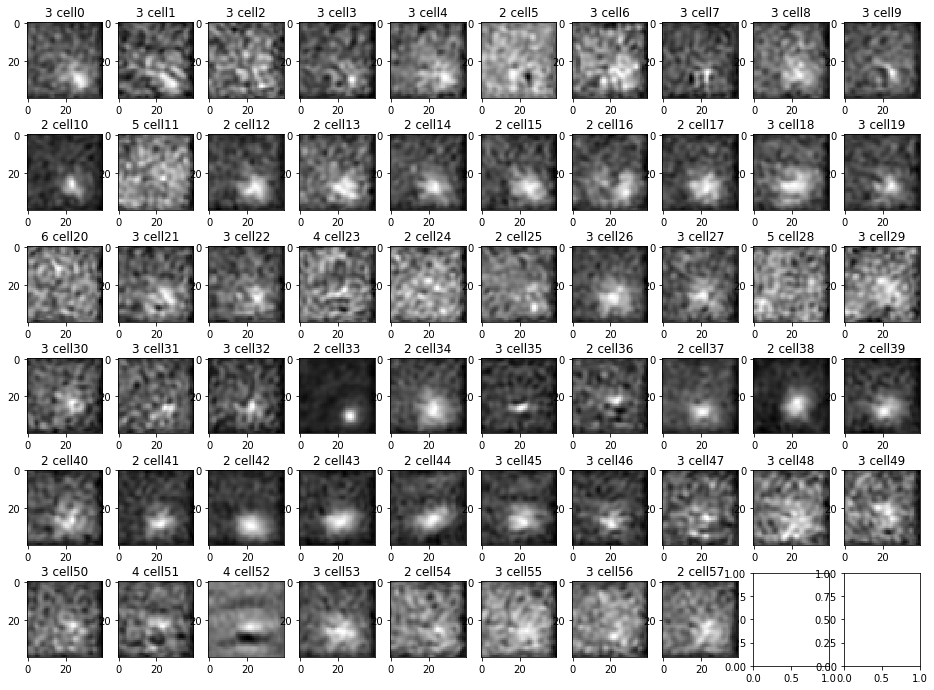

In [11]:
DU.subplot_setup(6,10)
for cc in range(NC):
    plt.subplot(6,10,cc+1)
    #plt.plot(np.transpose(stas[:,:,cc]))
    bestlag = np.argmax(np.max(abs(stas[:,:,cc]),axis=0))
    plt.imshow(np.reshape(stas[:,bestlag,cc], [NX, NY]), cmap='gray')  #RdBu_r 
               #vmin=-np.max(abs(stas[:,:,cc])), vmax=np.max(abs(stas[:,:,cc])))
    plt.title(str(bestlag)+' cell'+str(cc),)
plt.show()

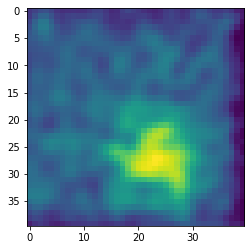

In [15]:
sumdensity = np.zeros([NX*NX])
for cc in range(NC):
    bestlag = np.argmax(np.max(abs(stas[:,:,cc]),axis=0))
    sumdensity += abs(stas[:,bestlag,cc])
plt.imshow(np.reshape(sumdensity, [NX,NX]))
plt.show()

24


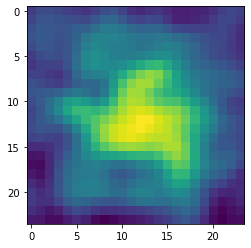

In [16]:
Cindx = crop_indx( NX, range(11, 35), range(15,39) )
NX2 = np.sqrt(len(Cindx)).astype(int)
print(NX2)
plt.imshow(np.reshape(sumdensity[Cindx],[NX2,NX2]))
plt.show()

In [17]:
# Make smaller Xstim (replacing larger)
num_lags = 10
Xstim = NDNutils.create_time_embedding( stim[:, Cindx], [num_lags, NX2, NX2], tent_spacing=1 )[valdata,:]

## Shared NIMs

In [31]:
# Regularization parameters arrived at though initial playing (on different notebook)
Greg0 = None
Mreg0 = 1e-6
L1reg0 = 1e-5

L1reg = 0.002
XTreg = 0.05
Mreg = 0.1 
Greg = 0.1

In [19]:
# Best configuation of shared NIM (roughly)
num_subs = 36
nim_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NX2,NX2, num_lags], layer_sizes=[num_subs, NC], 
    layer_types=['normal','normal'], ei_layers=[num_subs//2],
    normalization=[1,-1], act_funcs=['relu', 'softplus'], verbose=True,
    reg_list={'d2xt':[XTreg], 'l1':[L1reg0], 'glocal':[Greg0], 'max':[None,Mreg0]})

snim0 = NDN.NDN( nim_par, noise_dist='poisson' )
_ = snim0.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=False, 
                   learning_alg='adam', opt_params=adam_params, output_dir=output_dir )
snim0.set_regularization('glocal', Greg, layer_target=0)
snim0.set_regularization('l1', L1reg, layer_target=0)
snim0.set_regularization('max', Mreg, layer_target=1)
_ = snim0.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=False, 
                   learning_alg='adam', opt_params=adam_params, output_dir=output_dir )

LLs1 = snim0.eval_models(input_data=Xstim, output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=False)
LLs1n = snim0.eval_models(input_data=Xstim, output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=True)
print(np.mean(LLs1), np.mean(LLs1n))

Input dimensions: [1, 24, 24, 10]
0: normal (relu):  	[E18/I18] N
1: normal (softplus):  	[E58/I0] N+
Epoch 0000:  avg train cost =     4.2153,  avg test cost =     4.3238,  reg penalty =     0.3647
Epoch 0029:  avg train cost =     3.2909,  avg test cost =     3.5186,  reg penalty =     0.0786
Epoch 0059:  avg train cost =     3.2536,  avg test cost =     3.4462,  reg penalty =     0.0690
Epoch 0089:  avg train cost =     3.2436,  avg test cost =     3.4219,  reg penalty =     0.0630
Epoch 0119:  avg train cost =     3.2387,  avg test cost =     3.4149,  reg penalty =     0.0602
Epoch 0149:  avg train cost =     3.2351,  avg test cost =     3.4096,  reg penalty =     0.0589
Epoch 0179:  avg train cost =     3.2319,  avg test cost =     3.4076,  reg penalty =     0.0583
Epoch 0209:  avg train cost =     3.2289,  avg test cost =     3.4065,  reg penalty =     0.0579
Epoch 0239:  avg train cost =     3.2264,  avg test cost =     3.4064,  reg penalty =     0.0578

*** early stop criteria 

In [20]:
snim0.save_model(dirname+'pkls/d1231snim0.pkl')

Model pickled to /home/dbutts/Marmo/pkls/d1231snim0.pkl


In [32]:
# Best configuation of shared NIM (roughly)
num_subs = 36
nim_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NX2,NX2, num_lags], layer_sizes=[num_subs, NC], 
    layer_types=['normal','normal'], ei_layers=[num_subs//2],
    normalization=[1,-1], act_funcs=['relu', 'softplus'], verbose=True,
    reg_list={'d2xt':[XTreg], 'l1':[L1reg0], 'glocal':[Greg0], 'max':[None,Mreg0]})

snim0 = NDN.NDN( nim_par, noise_dist='poisson' )
_ = snim0.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=False, 
                   learning_alg='adam', opt_params=adam_params, output_dir=output_dir )
# put on localization and max penalty
snim0.set_regularization('glocal', Greg, layer_target=0)
snim0.set_regularization('max', Mreg, layer_target=1)
_ = snim0.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=False, 
                   learning_alg='adam', opt_params=adam_params, output_dir=output_dir )
# Now apply l1
snim0.set_regularization('l1', L1reg, layer_target=0)
_ = snim0.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=False, 
                   learning_alg='adam', opt_params=adam_params, output_dir=output_dir )

LLs1 = snim0.eval_models(input_data=Xstim, output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=False)
LLs1n = snim0.eval_models(input_data=Xstim, output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=True)
print(np.mean(LLs1), np.mean(LLs1n))

Input dimensions: [1, 24, 24, 10]
0: normal (relu):  	[E18/I18] N
1: normal (softplus):  	[E58/I0] N+
Epoch 0000:  avg train cost =     4.1813,  avg test cost =     4.2951,  reg penalty =     0.3895
Epoch 0029:  avg train cost =     3.2834,  avg test cost =     3.5127,  reg penalty =     0.0785
Epoch 0059:  avg train cost =     3.2472,  avg test cost =     3.4435,  reg penalty =     0.0694
Epoch 0089:  avg train cost =     3.2366,  avg test cost =     3.4211,  reg penalty =     0.0637
Epoch 0119:  avg train cost =     3.2306,  avg test cost =     3.4162,  reg penalty =     0.0609
Epoch 0149:  avg train cost =     3.2269,  avg test cost =     3.4128,  reg penalty =     0.0596
Epoch 0179:  avg train cost =     3.2236,  avg test cost =     3.4111,  reg penalty =     0.0589
Epoch 0209:  avg train cost =     3.2208,  avg test cost =     3.4129,  reg penalty =     0.0587

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 222,  end cost: 201.498682
     --->

In [33]:
snim0.save_model(dirname+'pkls/d1231snim0.pkl')

Model pickled to /home/dbutts/Marmo/pkls/d1231snim0.pkl


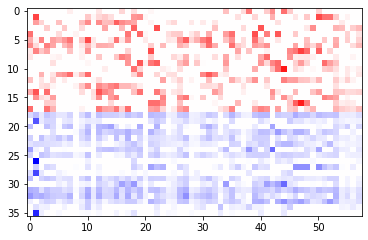

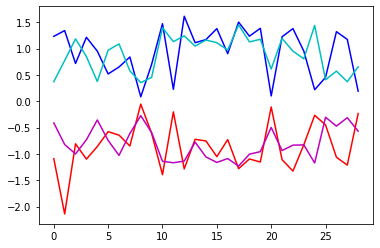

In [20]:
ws = snim0.networks[0].layers[1].weights.copy()
ws[range(18,36),:] *= -1
plt.imshow(ws, cmap='bwr', vmin=-np.max(abs(ws)), vmax=np.max(abs(ws)))
plt.show()
# any patterns of connectivity (hard to say)
plt.plot(np.sum(np.maximum(ws[:,range(58//2)],0), axis=0),'b')
plt.plot(np.sum(np.maximum(ws[:,range(58//2,58)],0), axis=0),'c')
plt.plot(np.sum(np.minimum(ws[:,range(58//2)],0), axis=0),'r')
plt.plot(np.sum(np.minimum(ws[:,range(58//2,58)],0), axis=0),'m')
plt.show()

## Deeper stim-only models

In [21]:
num_subs = 36
num_hid = 36

ndn_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NX2,NX2, num_lags], layer_sizes=[num_subs, num_hid, NC], 
    layer_types=['normal','normal','normal'], ei_layers=[num_subs//2, num_hid//2],
    normalization=[1,1, -1], act_funcs=['relu', 'relu', 'softplus'], verbose=True,
    reg_list={'d2xt':[XTreg], 'l1':[L1reg0], 'glocal':[Greg0], 'max':[None,None,Mreg0]})

ndn30 = NDN.NDN( ndn_par, noise_dist='poisson' )
_ = ndn30.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=False, 
                   learning_alg='adam', opt_params=adam_params, output_dir=output_dir )
ndn30.set_regularization('glocal', Greg, layer_target=0)
ndn30.set_regularization('l1', L1reg, layer_target=0)
ndn30.set_regularization('max', Mreg, layer_target=2)
_ = ndn30.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=False, 
                   learning_alg='adam', opt_params=adam_params, output_dir=output_dir )

LLs2 = ndn30.eval_models(input_data=Xstim, output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=False)
LLs2n = ndn30.eval_models(input_data=Xstim, output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=True)
print(np.mean(LLs2), np.mean(LLs2n))

Input dimensions: [1, 24, 24, 10]
0: normal (relu):  	[E18/I18] N
1: normal (relu):  	[E18/I18] N+
2: normal (softplus):  	[E58/I0] N+
Epoch 0000:  avg train cost =     3.9324,  avg test cost =     4.0670,  reg penalty =     0.2375
Epoch 0029:  avg train cost =     3.1947,  avg test cost =     3.4251,  reg penalty =     0.0603
Epoch 0059:  avg train cost =     3.1675,  avg test cost =     3.4033,  reg penalty =     0.0563
Epoch 0089:  avg train cost =     3.1545,  avg test cost =     3.4034,  reg penalty =     0.0559
Epoch 0119:  avg train cost =     3.1465,  avg test cost =     3.4162,  reg penalty =     0.0560

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 137,  end cost: 201.299073
     ---> best epoch: 61,  best cost: 200.280531

INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
Epoch 0000:  avg train cost =     3.2171,  avg test cost =     3.4001,  reg penalty =     0.1768
Epoch 0029:  avg train cos

### Scaffold

In [21]:
# Best regularization arrived at
Greg0 = None
Mreg0 = 1e-6
L1reg0 = 1e-5

L1reg = 0.003 # 0.01 optimal but RFs too sparse
XTreg = 0.01 # from 0.05
MIreg = 0.1
MSCreg = 10.0
Greg = 0.1

In [22]:
## SCAFFOLD
num_subs = 36
num_hid = 24

ndn_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NX2,NX2, num_lags], layer_sizes=[num_subs, num_hid], 
    layer_types=['normal','normal'], ei_layers=[num_subs//2, num_hid//2],
    normalization=[1,1], act_funcs=['relu', 'relu'], verbose=True,
    reg_list={'d2xt':[XTreg], 'l1':[L1reg0], 'glocal':[Greg0]})
side_par = NDNutils.ffnetwork_params( 
    network_type='side', xstim_n=None, ffnet_n=0, layer_sizes=[NC], 
    layer_types=['normal'], normalization=[-1], act_funcs=['softplus'], verbose=True,
    reg_list={'max':[Mreg0]})
side_par['pos_constraints']=True
side2 = NDN.NDN( [ndn_par, side_par], ffnet_out=1, noise_dist='poisson' )
_ = side2.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=False, 
                   learning_alg='adam', opt_params=adam_params, output_dir=output_dir )
side2.set_regularization('glocal', Greg, layer_target=0)
side2.set_regularization('l1', L1reg, layer_target=0)
side2.set_regularization('max', MIreg, ffnet_target=0, layer_target=1)
side2.set_regularization('max', MSCreg, ffnet_target=1, layer_target=0)
side2b = side2.copy_model()
_ = side2b.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=False, 
                   learning_alg='adam', opt_params=adam_params, output_dir=output_dir )

LLs2 = side2b.eval_models(input_data=Xstim, output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=False)
LLs2n = side2b.eval_models(input_data=Xstim, output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=True)
print(np.mean(LLs2), np.mean(LLs2n))

Input dimensions: [1, 24, 24, 10]
0: normal (relu):  	[E18/I18] N
1: normal (relu):  	[E12/I12] N+
0: normal (softplus):  	[E58/I0] N
Epoch 0000:  avg train cost =     4.1116,  avg test cost =     4.2339,  reg penalty =     0.1083
Epoch 0029:  avg train cost =     3.1635,  avg test cost =     3.4512,  reg penalty =     0.0376
Epoch 0059:  avg train cost =     3.1149,  avg test cost =     3.4408,  reg penalty =     0.0383
Epoch 0089:  avg train cost =     3.0960,  avg test cost =     3.4345,  reg penalty =     0.0393
Epoch 0119:  avg train cost =     3.0860,  avg test cost =     3.4383,  reg penalty =     0.0400

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 135,  end cost: 201.933484
     ---> best epoch: 94,  best cost: 201.280995

INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
Epoch 0000:  avg train cost =     3.1928,  avg test cost =     3.4080,  reg penalty =     1.4890
Epoch 0029:  avg train cost

In [23]:
side2b.save_model(dirname+'pkls/d1231csn0.pkl')

Model pickled to /home/dbutts/Marmo/pkls/d1231csn0.pkl


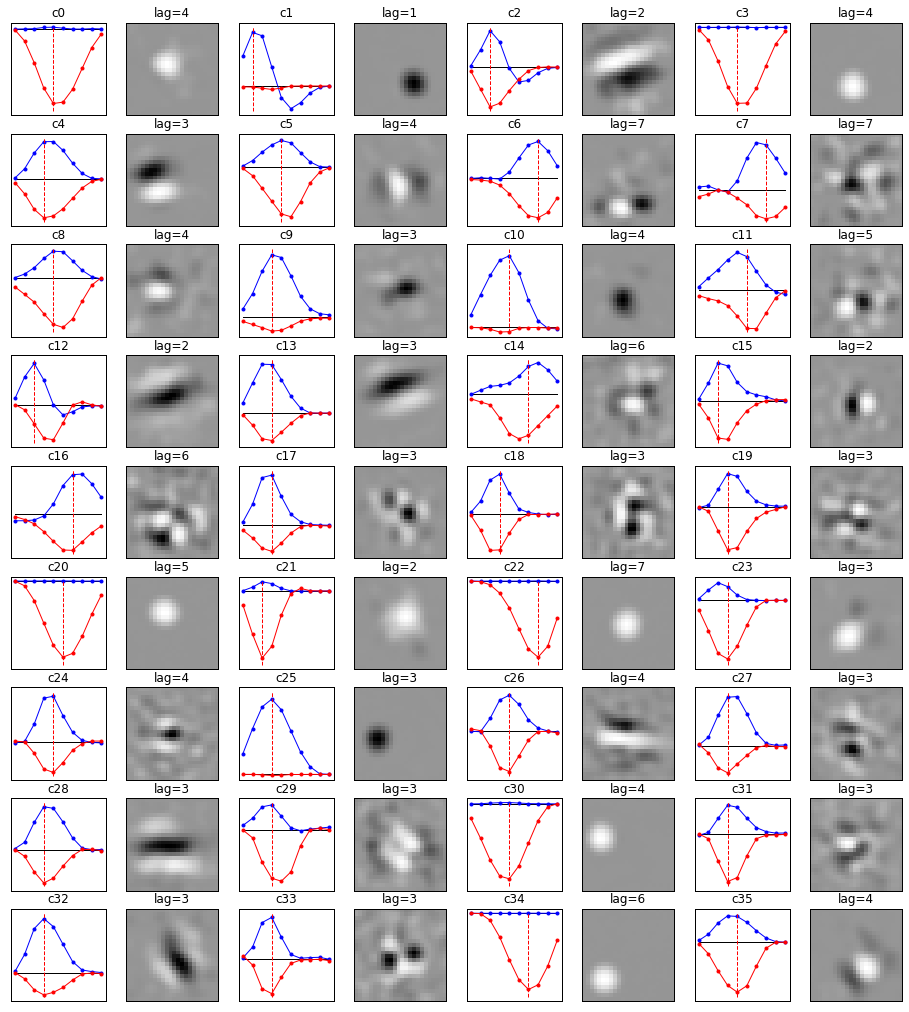

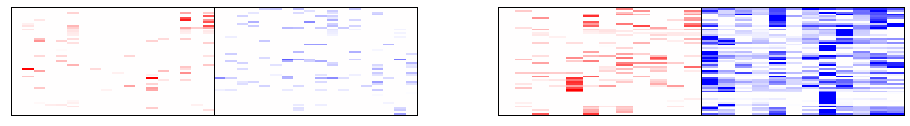

In [56]:
plot_3dfilters(side2b)
DU.scaffold_nonconv_plot(side2b) 

In [60]:
## Add extra step
num_subs = 36
num_hid = 24

ndn_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NX2,NX2, num_lags], layer_sizes=[num_subs, num_hid], 
    layer_types=['normal','normal'], ei_layers=[num_subs//2, num_hid//2],
    normalization=[1,1], act_funcs=['relu', 'relu'], verbose=True,
    reg_list={'d2xt':[XTreg], 'l1':[L1reg0], 'glocal':[Greg0]})
side_par = NDNutils.ffnetwork_params( 
    network_type='side', xstim_n=None, ffnet_n=0, layer_sizes=[NC], 
    layer_types=['normal'], normalization=[-1], act_funcs=['softplus'], verbose=True,
    reg_list={'max':[Mreg0]})
side_par['pos_constraints']=True
side2 = NDN.NDN( [ndn_par, side_par], ffnet_out=1, noise_dist='poisson' )
_ = side2.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=False, 
                   learning_alg='adam', opt_params=adam_params, output_dir=output_dir )
side2.set_regularization('glocal', Greg, layer_target=0)
side2.set_regularization('max', MIreg, ffnet_target=0, layer_target=1)
side2.set_regularization('max', MSCreg, ffnet_target=1, layer_target=0)
_ = side2.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=False, 
                   learning_alg='adam', opt_params=adam_params, output_dir=output_dir )

side2.set_regularization('l1', L1reg, layer_target=0)
side2b = side2.copy_model()
_ = side2b.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=False, 
                   learning_alg='adam', opt_params=adam_params, output_dir=output_dir )

LLs2 = side2b.eval_models(input_data=Xstim, output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=False)
LLs2n = side2b.eval_models(input_data=Xstim, output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=True)
print(np.mean(LLs2), np.mean(LLs2n))

Input dimensions: [1, 24, 24, 10]
0: normal (relu):  	[E18/I18] N
1: normal (relu):  	[E12/I12] N+
0: normal (softplus):  	[E58/I0] N
Epoch 0000:  avg train cost =     4.1692,  avg test cost =     4.2560,  reg penalty =     0.3404
Epoch 0029:  avg train cost =     3.2054,  avg test cost =     3.4317,  reg penalty =     0.0685
Epoch 0059:  avg train cost =     3.1702,  avg test cost =     3.4011,  reg penalty =     0.0640
Epoch 0089:  avg train cost =     3.1549,  avg test cost =     3.3996,  reg penalty =     0.0637
Epoch 0119:  avg train cost =     3.1444,  avg test cost =     3.3972,  reg penalty =     0.0638
Epoch 0149:  avg train cost =     3.1374,  avg test cost =     3.3970,  reg penalty =     0.0638

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 169,  end cost: 200.821464
     ---> best epoch: 142,  best cost: 200.494584

INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
Epoch 0000:  avg train cos

0 (l1 = 1e-06): 3.255961
1 (l1 = 0.0001): 3.2554898
2 (l1 = 0.001): 3.248769
3 (l1 = 0.01): 3.2379928
4 (l1 = 0.1): 3.290161
5 (l1 = 1.0): 3.3672109


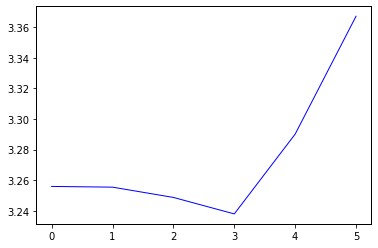

In [74]:
# Check L1 regularization in this context
rvals = [1e-6, 1e-4, 0.001, 0.01, 0.1, 1.0]
LLsL, RmodsL = NDNutils.reg_path(
    ndn_mod=side2, input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi,
    reg_type='l1', reg_vals=rvals, ffnet_target=0, layer_target=0, opt_params=adam_params)
plt.plot(LLsL,'b')
plt.show()# Check d2xt as well (once L1 optimized -- seems a little smooth)

0 (d2xt = 1e-06): 3.25171
1 (d2xt = 0.0001): 3.251106
2 (d2xt = 0.001): 3.2500086
3 (d2xt = 0.01): 3.2430148
4 (d2xt = 0.1): 3.248251
5 (d2xt = 1.0): 3.3035216


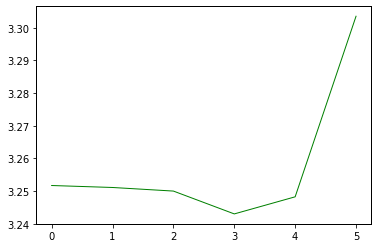

In [75]:
# Check L1 regularization in this context
rvals = [1e-6, 1e-4, 0.001, 0.01, 0.1, 1.0]
LLsX, RmodsX = NDNutils.reg_path(
    ndn_mod=side2, input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi,
    reg_type='d2xt', reg_vals=rvals, ffnet_target=0, layer_target=0, opt_params=adam_params)
plt.plot(LLsX,'g')
plt.show()# Check d2xt as well (once L1 optimized -- seems a little smooth)

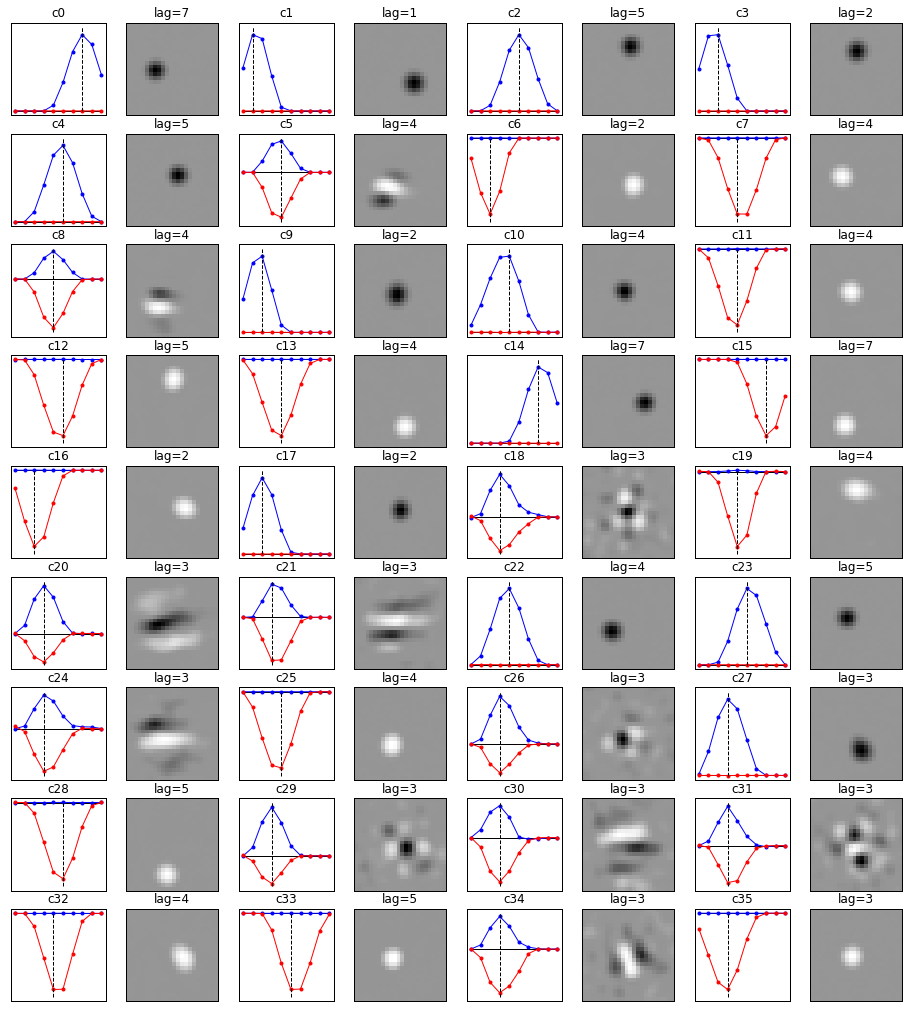

In [78]:
## TWO STAGE -- get subunit connectivity and then beef up L1 at the end
plot_3dfilters(RmodsL[3])
#DU.scaffold_nonconv_plot(side2b) 

0 (max = 1e-06): 3.3586128
1 (max = 0.0001): 3.3535628
2 (max = 0.001): 3.3534663
3 (max = 0.01): 3.3444579
4 (max = 0.1): 3.3253663
5 (max = 1.0): 3.2859619


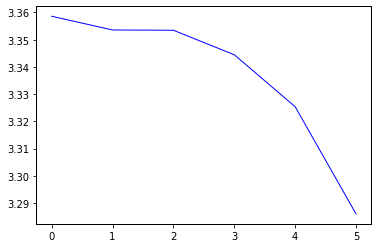

In [30]:
rvals = [1e-6, 1e-4, 0.001, 0.01, 0.1, 1.0]
LLsM, RmodsM = NDNutils.reg_path(
    ndn_mod=sideX2, input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi,
    reg_type='max', reg_vals=rvals, ffnet_target=1, layer_target=0, opt_params=adam_params)
plt.plot(LLsM,'b')
plt.show()

0 (max = 1.0): 3.2859619
1 (max = 2.0): 3.2811167
2 (max = 4.0): 3.2756348
3 (max = 10.0): 3.2699556


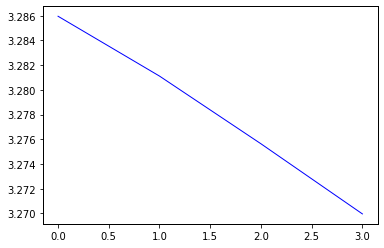

In [31]:
rvals = [1.0, 2.0,4.0,10.0]
LLsM2, RmodsM2 = NDNutils.reg_path(
    ndn_mod=sideX2, input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi,
    reg_type='max', reg_vals=rvals, ffnet_target=1, layer_target=0, opt_params=adam_params)
plt.plot(LLsM2,'b')
plt.show()

In [34]:
def plot_pop_subunit_weights(ws, num_inh=None):
    ws_play = deepcopy(ws)
    Ndim, Nsub = ws.shape
    if num_inh is not None:
        ws_play[range(Ndim-num_inh, Ndim),:] *= -1
    m = np.max(abs(ws_play))
    plt.imshow(ws_play, cmap='bwr', vmin=-m, vmax=m)

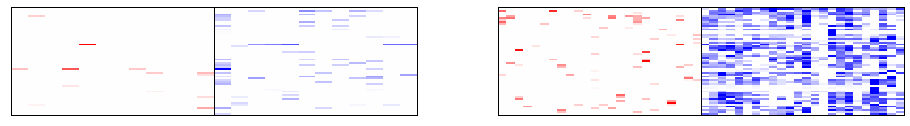

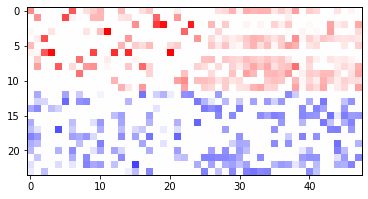

In [35]:
# Weights between first and second layer
plot_pop_subunit_weights(RmodsM2[-1].networks[0].layers[1].weights, 12)
# Weights to output
DU.scaffold_nonconv_plot(RmodsM2[-1])

In [89]:
# Deeper model
num_subs = 36
num_hid = 24

ndn_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NX2,NX2, num_lags], layer_sizes=[num_subs, num_hid, num_hid], 
    layer_types=['normal','normal','normal'], ei_layers=[num_subs//2, num_hid//2, num_hid//2],
    normalization=[1,1,1], act_funcs=['relu', 'relu', 'relu'], verbose=True,
    reg_list={'d2xt':[XTreg], 'l1':[L1reg0], 'glocal':[Greg0]})
side_par = NDNutils.ffnetwork_params( 
    network_type='side', xstim_n=None, ffnet_n=0, layer_sizes=[NC], 
    layer_types=['normal'], normalization=[-1], act_funcs=['softplus'], verbose=True,
    reg_list={'max':[Mreg0]})
side_par['pos_constraints']=True
side3 = NDN.NDN( [ndn_par, side_par], ffnet_out=1, noise_dist='poisson' )
_ = side3.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=False, 
                   learning_alg='adam', opt_params=adam_params, output_dir=output_dir )
side3.set_regularization('glocal', Greg, layer_target=0)
side3.set_regularization('max', MIreg, ffnet_target=0, layer_target=1)
side3.set_regularization('max', MIreg, ffnet_target=0, layer_target=2)
side3.set_regularization('max', MSCreg, ffnet_target=1, layer_target=0)
_ = side3.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=False, 
                   learning_alg='adam', opt_params=adam_params, output_dir=output_dir )

side3.set_regularization('l1', L1reg, layer_target=0)
side3b = side3.copy_model()
_ = side3b.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=False, 
                   learning_alg='adam', opt_params=adam_params, output_dir=output_dir )

LLs3 = side3b.eval_models(input_data=Xstim, output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=False)
LLs3n = side3b.eval_models(input_data=Xstim, output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=True)
print(np.mean(LLs2), np.mean(LLs2n))

Input dimensions: [1, 24, 24, 10]
0: normal (relu):  	[E18/I18] N
1: normal (relu):  	[E12/I12] N+
2: normal (relu):  	[E12/I12] N+
0: normal (softplus):  	[E58/I0] N
Epoch 0000:  avg train cost =     4.0637,  avg test cost =     4.1672,  reg penalty =     0.1118
Epoch 0029:  avg train cost =     3.1329,  avg test cost =     3.3925,  reg penalty =     0.0348
Epoch 0059:  avg train cost =     3.0945,  avg test cost =     3.4026,  reg penalty =     0.0366
Epoch 0089:  avg train cost =     3.0771,  avg test cost =     3.4093,  reg penalty =     0.0380

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 111,  end cost: 200.271455
     ---> best epoch: 23,  best cost: 198.722069

INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
Epoch 0000:  avg train cost =     3.2244,  avg test cost =     3.3642,  reg penalty =     1.3871
Epoch 0029:  avg train cost =     3.1717,  avg test cost =     3.3007,  reg penalty =     0

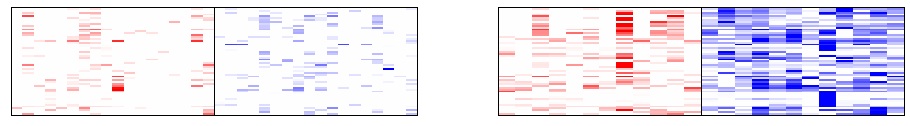

In [88]:
#DU.plot_3dfilters(side3b)
DU.scaffold_nonconv_plot(side3b)

No better than with two

In [37]:
## ASSUME FIRST LAYER 
sublist=[16, 24, 32, 40, 48, 60]
num_hid = 48

Niter = len(sublist)
LLsSCsubs = np.zeros(Niter)
SCsub_mods = []

side_par = NDNutils.ffnetwork_params( 
    network_type='side', xstim_n=None, ffnet_n=0, layer_sizes=[NC], 
    layer_types=['normal'], normalization=[-1], act_funcs=['softplus'], verbose=False,
    reg_list={'max':[Mreg0]})
side_par['pos_constraints']=True

for nn in range(Niter):

    ndn_par = NDNutils.ffnetwork_params( 
        input_dims=[1,NX2,NX2, num_lags], layer_sizes=[sublist[nn], num_hid], 
        layer_types=['normal','normal'], ei_layers=[sublist[nn]//2, num_hid//2],
        normalization=[1,1], act_funcs=['relu', 'relu'], verbose=False,
        reg_list={'d2xt':[XTreg], 'l1':[L1reg0], 'glocal':[Greg0]})
    side_iter = NDN.NDN( [ndn_par, side_par], ffnet_out=1, noise_dist='poisson' )
    _ = side_iter.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=False, 
                       learning_alg='adam', opt_params=adam_params, output_dir=output_dir )
    side_iter.set_regularization('glocal', Greg, layer_target=0)
    side_iter.set_regularization('l1', L1reg, layer_target=0)
    side_iter.set_regularization('max', MSCreg, ffnet_target=1, layer_target=0)
    _ = side_iter.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=False, 
                       learning_alg='adam', opt_params=adam_params, output_dir=output_dir )

    LLs = side_iter.eval_models(input_data=Xstim, output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=False)
    LLsSCsubs[nn] = np.mean(LLs)
    SCsub_mods.append(side_iter.copy_model())
    print( sublist[nn], LLsSCsubs)

Epoch 0000:  avg train cost =     4.0775,  avg test cost =     4.1883,  reg penalty =     0.0848
Epoch 0029:  avg train cost =     3.2523,  avg test cost =     3.4224,  reg penalty =     0.0490
Epoch 0059:  avg train cost =     3.2310,  avg test cost =     3.3993,  reg penalty =     0.0442
Epoch 0089:  avg train cost =     3.2211,  avg test cost =     3.3918,  reg penalty =     0.0433
Epoch 0119:  avg train cost =     3.2150,  avg test cost =     3.3956,  reg penalty =     0.0432
Epoch 0149:  avg train cost =     3.2116,  avg test cost =     3.3953,  reg penalty =     0.0431

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 164,  end cost: 199.484206
     ---> best epoch: 134,  best cost: 199.143604

INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
Epoch 0000:  avg train cost =     3.2824,  avg test cost =     3.4054,  reg penalty =     1.6069
Epoch 0029:  avg train cost =     3.2571,  avg test cost =     

In [41]:
    # TEST using max-norm for subunits instead of norm
    num_subs=40
    ndn_par = NDNutils.ffnetwork_params( 
        input_dims=[1,NX2,NX2, num_lags], layer_sizes=[num_subs, num_hid], 
        layer_types=['normal','normal'], ei_layers=[num_subs//2, num_hid//2],
        normalization=[-1,-1], act_funcs=['relu', 'relu'], verbose=False,
        reg_list={'d2xt':[XTreg], 'l1':[L1reg0], 'glocal':[Greg0]})
    side_iter = NDN.NDN( [ndn_par, side_par], ffnet_out=1, noise_dist='poisson' )
    _ = side_iter.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=False, 
                       learning_alg='adam', opt_params=adam_params, output_dir=output_dir )
    side_iter.set_regularization('glocal', Greg, layer_target=0)
    side_iter.set_regularization('l1', L1reg, layer_target=0)
    side_iter.set_regularization('max', MSCreg, ffnet_target=1, layer_target=0)
    _ = side_iter.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=False, 
                       learning_alg='adam', opt_params=adam_params, output_dir=output_dir )

    LLs = side_iter.eval_models(input_data=Xstim, output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=False)

Epoch 0000:  avg train cost =     4.0463,  avg test cost =     4.1590,  reg penalty =     0.2178
Epoch 0029:  avg train cost =     3.1932,  avg test cost =     3.3560,  reg penalty =     0.0555
Epoch 0059:  avg train cost =     3.1519,  avg test cost =     3.3676,  reg penalty =     0.0578
Epoch 0089:  avg train cost =     3.1338,  avg test cost =     3.3751,  reg penalty =     0.0603

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 115,  end cost: 199.867883
     ---> best epoch: 28,  best cost: 197.724321

INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
Epoch 0000:  avg train cost =     3.2900,  avg test cost =     3.3601,  reg penalty =     1.4317
Epoch 0029:  avg train cost =     3.2318,  avg test cost =     3.2836,  reg penalty =     0.0908
Epoch 0059:  avg train cost =     3.2286,  avg test cost =     3.2715,  reg penalty =     0.0858
Epoch 0089:  avg train cost =     3.2264,  avg test cost =     3

3.2543762 3.2473647594451904


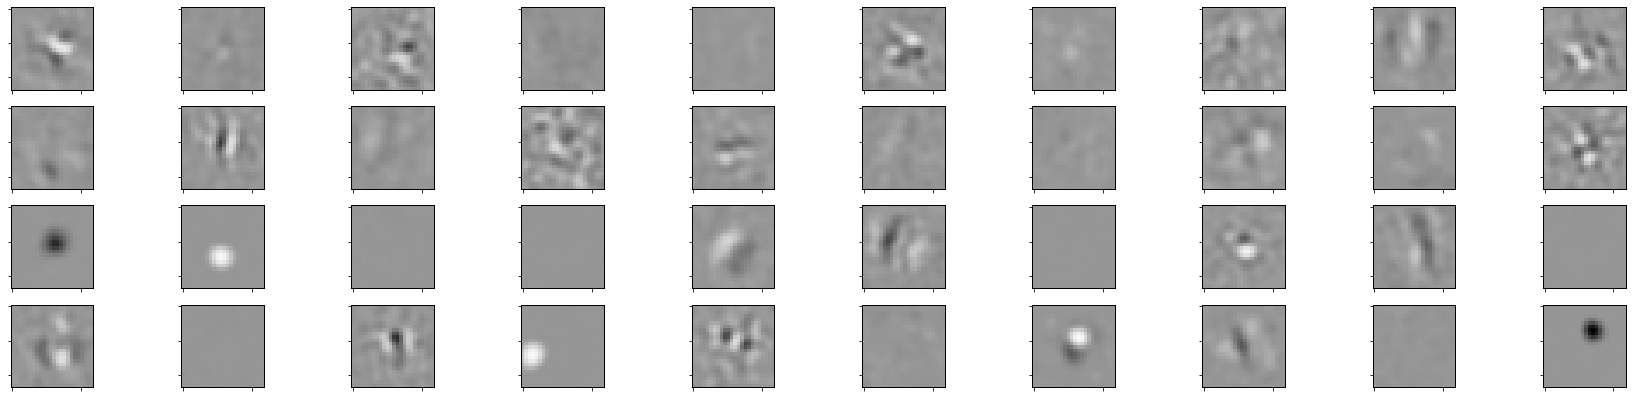

In [44]:
print(np.mean(LLs), LLsSCsubs[3])
DU.plot_filters(side_iter)

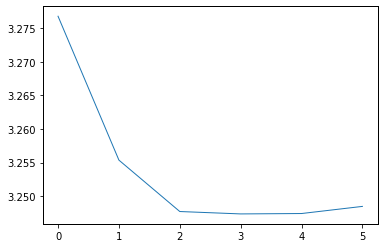

In [38]:
plt.plot(LLsSCsubs)
plt.show()

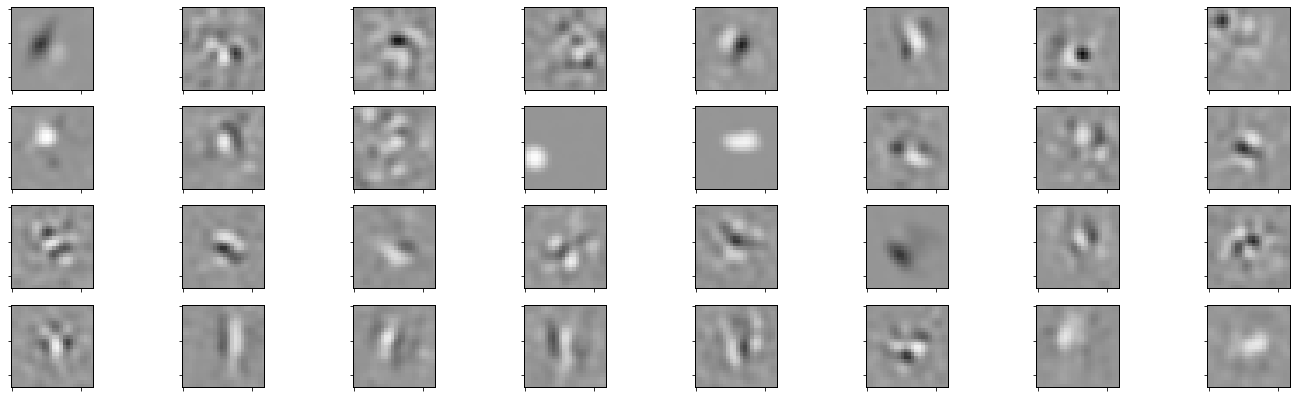

In [39]:
DU.plot_filters(SCsub_mods[2])

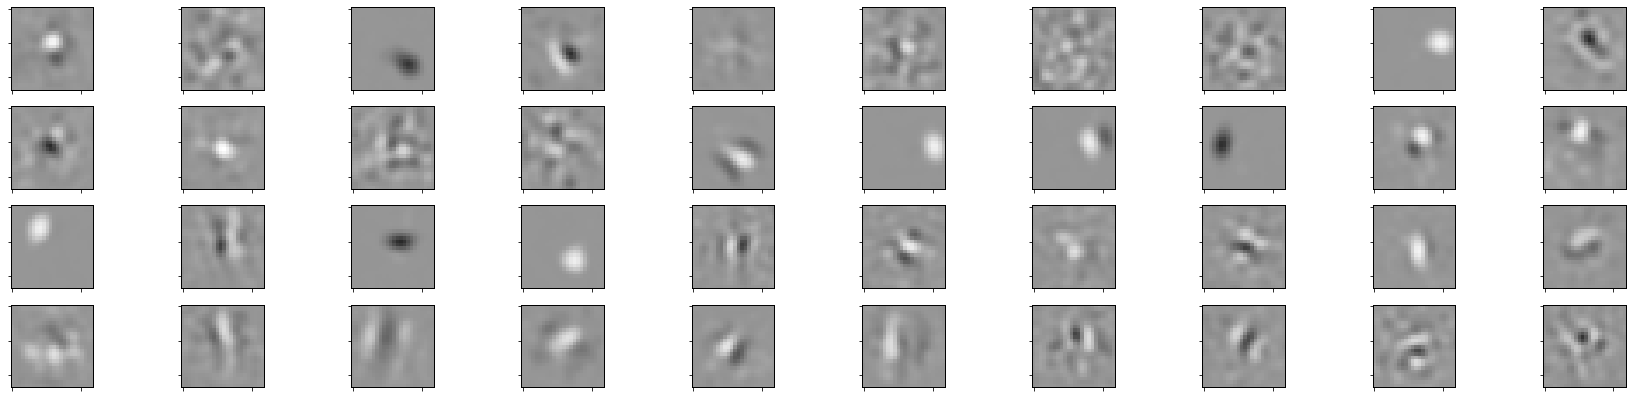

In [40]:
DU.plot_filters(SCsub_mods[3])

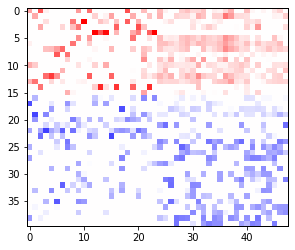

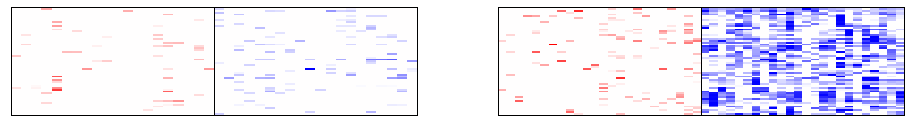

In [46]:
# Weights between first and second layer
plot_pop_subunit_weights(SCsub_mods[3].networks[0].layers[1].weights, 24)
# Weights to output
DU.scaffold_nonconv_plot(SCsub_mods[3])

In [ ]:
# Check to see if internal-max helps

INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
16 [3.25103474 0.         0.         0.         0.        ]
INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
24 [3.25103474 3.24907517 0.         0.         0.        ]
INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
32 [3.25103474 3.24907517 3.25479126 0.         0.        ]
INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
40 [3.25103474 3.24907517 3.25479126 3.2562604  0.        ]
INFO:ten

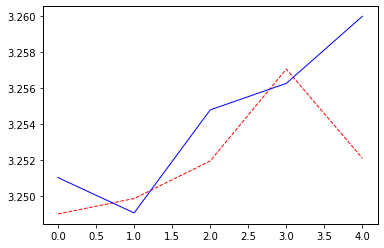

In [48]:
## Vary n-inhibition separately
## ASSUME FIRST LAYER 
num_Ehid = 32
sublist=[16, 24, 32, 40, 48]  # num_Ihid
num_subs = 32

Niter = len(sublist)
LLsSCIhid2 = np.zeros(Niter)
SCsubIhid2_mods = []

side_par = NDNutils.ffnetwork_params( 
    network_type='side', xstim_n=None, ffnet_n=0, layer_sizes=[NC], 
    layer_types=['normal'], normalization=[-1], act_funcs=['softplus'], verbose=False,
    reg_list={'max':[Mreg0]})
side_par['pos_constraints']=True

for nn in range(Niter):

    ndn_par = NDNutils.ffnetwork_params( 
        input_dims=[1,NX2,NX2, num_lags], layer_sizes=[num_subs, num_Ehid+sublist[nn]], 
        layer_types=['normal','normal'], ei_layers=[num_subs//2, sublist[nn]],
        normalization=[1,1], act_funcs=['relu', 'relu'], verbose=False,
        reg_list={'d2xt':[XTreg], 'l1':[L1reg0], 'glocal':[Greg0]})
    side_iter = NDN.NDN( [ndn_par, side_par], ffnet_out=1, noise_dist='poisson' )
    _ = side_iter.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=True, 
                       learning_alg='adam', opt_params=adam_params, output_dir=output_dir )
    side_iter.set_regularization('glocal', Greg, layer_target=0)
    side_iter.set_regularization('l1', L1reg, layer_target=0)
    side_iter.set_regularization('max', MSCreg, ffnet_target=1, layer_target=0)
    _ = side_iter.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=True, 
                       learning_alg='adam', opt_params=adam_params, output_dir=output_dir )

    LLs = side_iter.eval_models(input_data=Xstim, output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=False)
    LLsSCIhid2[nn] = np.mean(LLs)
    SCsubIhid2_mods.append(side_iter.copy_model())
    print( sublist[nn], LLsSCIhid2)

plt.plot(LLsSCIhid,'r--')
plt.plot(LLsSCIhid2,'b')
plt.show()

In [49]:
## Vary n-inhibition separately
## ASSUME FIRST LAYER 
num_Ehid = 32
num_Ihid = 32
num_subs = 32

Niter = len(sublist)
LLsSCIhid2 = np.zeros(Niter)
SCsubIhid2_mods = []

side_par = NDNutils.ffnetwork_params( 
    network_type='side', xstim_n=None, ffnet_n=0, layer_sizes=[NC], 
    layer_types=['normal'], normalization=[-1], act_funcs=['softplus'], verbose=False,
    reg_list={'max':[Mreg0]})
side_par['pos_constraints']=True

ndn_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NX2,NX2, num_lags], layer_sizes=[num_subs, num_Ehid+num_Ihid], 
    layer_types=['normal','normal'], ei_layers=[num_subs//2, num_Ehid//2],
    normalization=[1,1], act_funcs=['relu', 'relu'], verbose=False,
    reg_list={'d2xt':[XTreg], 'l1':[L1reg0], 'glocal':[Greg0]})
side_iter = NDN.NDN( [ndn_par, side_par], ffnet_out=1, noise_dist='poisson' )
_ = side_iter.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=True, 
                   learning_alg='adam', opt_params=adam_params, output_dir=output_dir )
side_iter.set_regularization('glocal', Greg, layer_target=0)
side_iter.set_regularization('l1', L1reg, layer_target=0)
side_iter.set_regularization('max', MSCreg, ffnet_target=1, layer_target=0)

INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model


0 (max = 1e-06): 3.2751162
1 (max = 0.0001): 3.2737947
2 (max = 0.001): 3.2722814
3 (max = 0.01): 3.2716541
4 (max = 0.1): 3.2446058
5 (max = 1.0): 3.2745547
6 (max = 10): 3.2983153


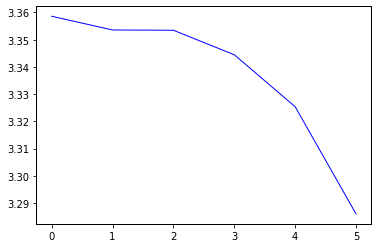

In [50]:
rvals = [1e-6, 1e-4, 0.001, 0.01, 0.1, 1.0, 10]
LLsMI, RmodsMI = NDNutils.reg_path(
    ndn_mod=side_iter, input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi,
    reg_type='max', reg_vals=rvals, ffnet_target=0, layer_target=1, opt_params=adam_params)
plt.plot(LLsMI,'b')
plt.show()

INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
16 [3.24902034 0.         0.         0.         0.        ]
INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
24 [3.24902034 3.24987435 0.         0.         0.        ]
INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
32 [3.24902034 3.24987435 3.25195789 0.         0.        ]
INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
INFO:tensorflow:Restoring parameters from /home/dbutts/V1/pkls/output_dir0/bstmods/best_model
40 [3.24902034 3.24987435 3.25195789 3.25705194 0.        ]
INFO:ten

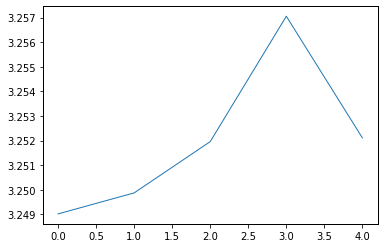

In [47]:
## Vary n-inhibition separately
## ASSUME FIRST LAYER 
num_Ehid = 16
sublist=[16, 24, 32, 40, 48]  # num_Ihid
num_subs = 32

Niter = len(sublist)
LLsSCIhid = np.zeros(Niter)
SCsubIhid_mods = []

side_par = NDNutils.ffnetwork_params( 
    network_type='side', xstim_n=None, ffnet_n=0, layer_sizes=[NC], 
    layer_types=['normal'], normalization=[-1], act_funcs=['softplus'], verbose=False,
    reg_list={'max':[Mreg0]})
side_par['pos_constraints']=True

for nn in range(Niter):

    ndn_par = NDNutils.ffnetwork_params( 
        input_dims=[1,NX2,NX2, num_lags], layer_sizes=[num_subs, num_Ehid+sublist[nn]], 
        layer_types=['normal','normal'], ei_layers=[num_subs//2, sublist[nn]],
        normalization=[1,1], act_funcs=['relu', 'relu'], verbose=False,
        reg_list={'d2xt':[XTreg], 'l1':[L1reg0], 'glocal':[Greg0]})
    side_iter = NDN.NDN( [ndn_par, side_par], ffnet_out=1, noise_dist='poisson' )
    _ = side_iter.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=True, 
                       learning_alg='adam', opt_params=adam_params, output_dir=output_dir )
    side_iter.set_regularization('glocal', Greg, layer_target=0)
    side_iter.set_regularization('l1', L1reg, layer_target=0)
    side_iter.set_regularization('max', MSCreg, ffnet_target=1, layer_target=0)
    _ = side_iter.train(input_data=Xstim, output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi, silent=True, 
                       learning_alg='adam', opt_params=adam_params, output_dir=output_dir )

    LLs = side_iter.eval_models(input_data=Xstim, output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=False)
    LLsSCIhid[nn] = np.mean(LLs)
    SCsubIhid_mods.append(side_iter.copy_model())
    print( sublist[nn], LLsSCIhid)
plt.plot(LLsSCIhid)
plt.show()

## Saccadic kernels

In [25]:
num_saclags = 20
Xsac1 = NDNutils.create_time_embedding(sac_on, [num_saclags, 1, 1], tent_spacing=1)
Xsac2 = NDNutils.create_time_embedding(sac_off, [num_saclags, 1, 1], tent_spacing=1)
TSreg = 0.0001

In [26]:
prev_mod = side2b.copy_model()

In [93]:
# With side model for stimulus
num_subs = 36
num_hid = 24

ndn_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NX2,NX2, num_lags], layer_sizes=[num_subs, num_hid], 
    layer_types=['normal','normal'], ei_layers=[num_subs//2, num_hid//2],
    normalization=[1,1], act_funcs=['relu', 'relu'], verbose=True,
    reg_list={'d2xt':[XTreg], 'l1':[L1reg], 'glocal':[Greg], 'max':[MIreg, MIreg]})
side_par = NDNutils.ffnetwork_params( 
    network_type='side', xstim_n=None, ffnet_n=0, layer_sizes=[NC], 
    layer_types=['normal'], normalization=[-1], act_funcs=['lin'], verbose=True, # changed to lin from softplus
    reg_list={'max':[MSCreg]})
side_par['pos_constraints']=True

# Saccade params that added together
sac1_par = NDNutils.ffnetwork_params( 
    input_dims=[1,1,1, num_saclags], xstim_n=[1],
    layer_sizes=[1, NC], layer_types=['normal', 'normal'], normalization=[1,0], 
    act_funcs=['relu', 'lin'], reg_list={'d2t':[TSreg]})  # make rectified, but don't have to
sac2_par = NDNutils.ffnetwork_params( 
    input_dims=[1,1,1, num_saclags], xstim_n=[2],
    layer_sizes=[1, NC], layer_types=['normal', 'normal'], normalization=[1, 0], act_funcs=['relu', 'lin'],
    reg_list={'d2t':[TSreg]})
comb_par = NDNutils.ffnetwork_params( 
    xstim_n=None, ffnet_n=[1,2,3], layer_sizes=[NC], layer_types=['add'], act_funcs=['softplus'])

sacnim1 = NDN.NDN( [ndn_par, side_par, sac1_par, sac2_par, comb_par], ffnet_out=4, noise_dist='poisson' )
sacnim1.networks[0].layers[0].weights = deepcopy(prev_mod.networks[0].layers[0].weights)
sacnim1.networks[0].layers[0].biases = deepcopy(prev_mod.networks[0].layers[0].biases)
sacnim1.networks[0].layers[1].weights = deepcopy(prev_mod.networks[0].layers[1].weights)
sacnim1.networks[0].layers[1].biases = deepcopy(prev_mod.networks[0].layers[1].biases)
sacnim1.networks[1].layers[0].weights = deepcopy(prev_mod.networks[1].layers[0].weights)

# initially just fit saccade kernels
v2f0 = sacnim1.fit_variables(layers_to_skip=[[0,1],[0]], fit_biases=True)
v2f0[2][1]['biases']=False
v2f0[3][1]['biases']=False
v2f0[4][0]['weights']=False

# Then can fit everything but temporal kernels for stim
v2f = sacnim1.fit_variables(layers_to_skip=[[],[],[],[],[0]], fit_biases=True)
v2f[1][0]['biases']=False
v2f[2][1]['biases']=False
v2f[3][1]['biases']=False

_ = sacnim1.train(
    input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], output_data=Robs[valdata,:], 
    train_indxs=Ui, test_indxs=Xi, fit_variables=v2f0, 
    learning_alg='adam', opt_params=adam_params, output_dir=output_dir )
_ = sacnim1.train(
    input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], output_data=Robs[valdata,:], 
    train_indxs=Ui, test_indxs=Xi, fit_variables=v2f, 
    learning_alg='adam', opt_params=adam_params, output_dir=output_dir )

LLS1x = sacnim1.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=False)
LLS1n = sacnim1.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=True)

print(np.mean(LLS1x), np.mean(LLS1n))

Input dimensions: [1, 24, 24, 10]
0: normal (relu):  	[E18/I18] N
1: normal (relu):  	[E12/I12] N+
0: normal (lin):  	[E58/I0] N
Input dimensions: [1, 1, 1, 20]
0: normal (relu):  	[E1/I0] N
1: normal (lin):  	[E58/I0] 
Input dimensions: [1, 1, 1, 20]
0: normal (relu):  	[E1/I0] N
1: normal (lin):  	[E58/I0] 
0: add (softplus):  	[E58/I0] 
Epoch 0000:  avg train cost =     4.9195,  avg test cost =     4.9554,  reg penalty =     0.1759
Epoch 0089:  avg train cost =     3.2553,  avg test cost =     3.2754,  reg penalty =     0.1759
Epoch 0119:  avg train cost =     3.2543,  avg test cost =     3.2746,  reg penalty =     0.1759
Epoch 0149:  avg train cost =     3.2535,  avg test cost =     3.2740,  reg penalty =     0.1759
Epoch 0179:  avg train cost =     3.2529,  avg test cost =     3.2735,  reg penalty =     0.1759
Epoch 0209:  avg train cost =     3.2524,  avg test cost =     3.2731,  reg penalty =     0.1759
Epoch 0239:  avg train cost =     3.2521,  avg test cost =     3.2730,  reg 

This is a pretty good model, according to the LLs. Let's stick with this for saccadic modulation now.

In [96]:
sacnim1.save_model(dirname+'pkls/sacstim0.pkl')

Model pickled to /home/dbutts/Marmo/pkls/sacstim0.pkl


## Predictions for this stimulus, to verify models can produce same STAs

In [38]:
# Load best models (so far) -- which might already be in memeory
snim0 = NDN.NDN.load_model(dirname+'pkls/d1231snim0.pkl')
csn0 = NDN.NDN.load_model(dirname+'pkls/d1231csn0.pkl')
sacmod0 = NDN.NDN.load_model(dirname+'pkls/sacstim0.pkl')

In [43]:
# Regenerate stim -- if needed (although need full data)
num_lags = 10
Cindx = crop_indx( NX, range(11, 35), range(15,39) )
XstimAll = NDNutils.create_time_embedding( stim[:, Cindx], [num_lags, NX2, NX2], tent_spacing=1 )

In [46]:
# Check recalculated LLs Xsac1.shape
LLs0 = snim0.eval_models(input_data=XstimAll[valdata,:], output_data=Robs[valdata,:], 
                         data_indxs=Xi, nulladjusted=True)
LLs1 = csn0.eval_models(input_data=XstimAll[valdata,:], output_data=Robs[valdata,:], 
                        data_indxs=Xi, nulladjusted=True)
LLs2 = sacmod0.eval_models(input_data=[XstimAll[valdata,:], Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=True)
print(np.mean(LLs0), np.mean(LLs1), np.mean(LLs2))

0.26421982 0.31495985 0.35386553


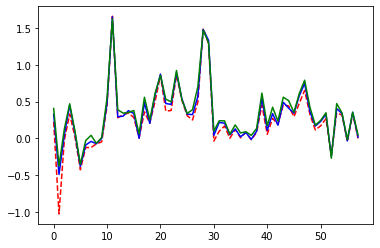

In [47]:
# Look at LLs across cells
plt.plot(LLs0,'r--')
plt.plot(LLs1,'b')
plt.plot(LLs2,'g')
plt.show()
# interesting -- note that the extra layers (and sac mod) help only a fraction of cells

In [83]:
pred0 = snim0.generate_prediction(input_data=XstimAll)
pred1 = csn0.generate_prediction(input_data=XstimAll)
pred2 = sacmod0.generate_prediction(input_data=[XstimAll, Xsac1, Xsac2])

250 201


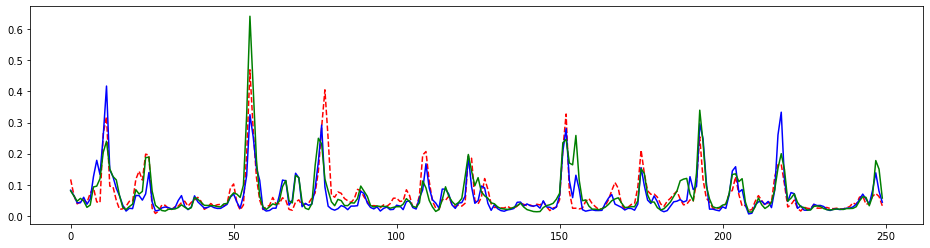

In [84]:
trange = range(3250,3500) # arbitrary window where most data is valid...
print(len(trange), len(np.intersect1d(trange,valdata)))
fig = plt.figure(figsize=(16, 4))
plt.plot(pred0[trange,cc],'r--')
plt.plot(pred1[trange,cc],'b')
plt.plot(pred2[trange,cc],'g')
plt.show()

#### These look like pretty well-modulated responses (!).

In [88]:
# Calculate predicted STAs of each neuron
stas = np.reshape(np.matmul(np.transpose(XstimAll[valdata,:]),Robs[valdata,:]), 
                      [NX2*NX2,num_lags, NC]) / len(valdata)

predstas = np.reshape(np.matmul(np.transpose(XstimAll[valdata,:]),pred1[valdata,:]), 
                      [NX2*NX2,num_lags, NC]) / len(valdata)
predstas.shape

(576, 10, 58)

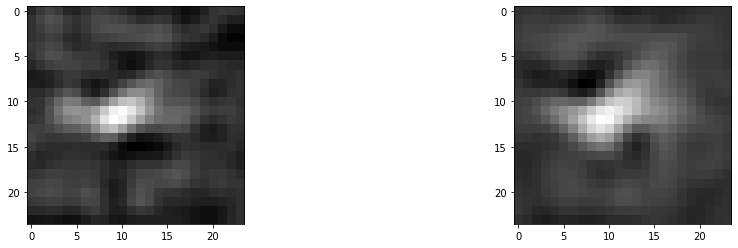

In [92]:
# Pick one of the good cells to compare
cc = 35
DU.subplot_setup(1,2, row_height=4)
plt.subplot(1,2,1)
plt.imshow(np.reshape(stas[:,3,cc],[NX2,NX2]), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(np.reshape(predstas[:,3,cc],[NX2,NX2]), cmap='gray')
plt.show()
# Not sure how closely they should look...

## Predictions for RSVP stim (and others)

In [74]:
# Load RSVP Stimulus
matdat = sio.loadmat('Data/L20191231_FixRsvpStim.mat')
stim4 = matdat['stim'].copy()
Robs4 = matdat['Robs'].copy()
valdat4 = matdat['valdata'].copy()
labels4 = matdat['labels'].copy()
valid4 = np.intersect1d(np.where(valdat4[:,0] == 1)[0], np.where(labels4[:,0] == 1)[0])
slist4 = matdat['slist'].astype(int)
ets4 = matdat['eyeAtFrame']
NT4 = Robs4.shape[0]

In [75]:
# Crop
Cindx = crop_indx( NX, range(11, 35), range(15,39) )
NX2 = np.sqrt(len(Cindx)).astype(int)
Xstim4 = NDNutils.create_time_embedding( stim4[:, Cindx], [num_lags, NX2, NX2], tent_spacing=1 )

In [ ]:
# And so on...

### Multiplicative gain modulation

In [27]:
ndn_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NX2,NX2, num_lags], layer_sizes=[num_subs, num_hid], 
    layer_types=['normal','normal'], ei_layers=[num_subs//2, num_hid//2],
    normalization=[1,1], act_funcs=['relu', 'relu'], verbose=True,
    reg_list={'d2xt':[XTreg], 'l1':[L1reg], 'glocal':[Greg], 'max':[MIreg, MIreg]})
side_par = NDNutils.ffnetwork_params( 
    network_type='side', xstim_n=None, ffnet_n=0, layer_sizes=[NC], 
    layer_types=['normal'], normalization=[-1], act_funcs=['lin'], verbose=True, # changed to lin from softplus
    reg_list={'max':[MSCreg]})
side_par['pos_constraints']=True

# Multiplicative modulation of saccade onset on the total stim term (for example)
sac1_par = NDNutils.ffnetwork_params( 
    input_dims=[1,1,1, num_saclags], xstim_n=[1],
    layer_sizes=[1, NC], layer_types=['normal', 'normal'], normalization=[1,0], act_funcs=['lin', 'lin'],
    reg_list={'d2t':[TSreg]})
stim_par = NDNutils.ffnetwork_params( 
    xstim_n=None, ffnet_n=[1,2],
    layer_sizes=[NC], layer_types=['mult'], normalization=[0], act_funcs=['lin'])
sac2_par = NDNutils.ffnetwork_params( 
    input_dims=[1,1,1, num_saclags], xstim_n=[2],
    layer_sizes=[1, NC], layer_types=['normal', 'normal'], normalization=[1, 0], act_funcs=['lin', 'lin'],
    reg_list={'d2t':[TSreg]})
comb_par = NDNutils.ffnetwork_params( 
    xstim_n=None, ffnet_n=[3,4], layer_sizes=[NC], layer_types=['add'], act_funcs=['softplus'])

gmodsac0 = NDN.NDN( [ndn_par, side_par, sac1_par, stim_par, sac2_par, comb_par], ffnet_out=5, noise_dist='poisson' )
gmodsac0.networks[0].layers[0].weights = deepcopy(prev_mod.networks[0].layers[0].weights)
gmodsac0.networks[0].layers[0].biases = deepcopy(prev_mod.networks[0].layers[0].biases)
gmodsac0.networks[0].layers[1].weights = deepcopy(prev_mod.networks[0].layers[1].weights)
gmodsac0.networks[0].layers[1].biases = deepcopy(prev_mod.networks[0].layers[1].biases)
gmodsac0.networks[1].layers[0].weights = deepcopy(prev_mod.networks[1].layers[0].weights)

v2f0 = gmodsac0.fit_variables(layers_to_skip=[[0,1],[0]], fit_biases=True)
v2f0[2][1]['biases']=False
v2f0[3][0]['biases']=False
v2f0[4][1]['biases']=False
v2f0[5][0]['weights']=False

v2f = gmodsac0.fit_variables(fit_biases=True)
v2f[1][0]['biases']=False
v2f[2][1]['biases']=False
v2f[3][0]['biases']=False
v2f[4][1]['biases']=False
v2f[5][0]['weights']=False

# dont fit stim terms yet
_ = gmodsac0.train(
    input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], output_data=Robs[valdata,:], 
    train_indxs=Ui, test_indxs=Xi, fit_variables=v2f0, 
    learning_alg='adam', opt_params=adam_params, output_dir=output_dir )

# now fit stim terms too 
_ = gmodsac0.train(
    input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], output_data=Robs[valdata,:], 
    train_indxs=Ui, test_indxs=Xi, fit_variables=v2f, 
    learning_alg='adam', opt_params=adam_params, output_dir=output_dir )

LL1x2 = gmodsac0.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=False)
LL1n2 = gmodsac0.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=True)

print(np.mean(LL1x), np.mean(LL1n))
print(np.mean(LL1x2), np.mean(LL1n2))

Input dimensions: [1, 24, 24, 10]
0: normal (relu):  	[E18/I18] N
1: normal (relu):  	[E12/I12] N+
0: normal (lin):  	[E58/I0] N
Input dimensions: [1, 1, 1, 20]
0: normal (lin):  	[E1/I0] N
1: normal (lin):  	[E58/I0] 
0: mult (lin):  	[E58/I0] 
Input dimensions: [1, 1, 1, 20]
0: normal (lin):  	[E1/I0] N
1: normal (lin):  	[E58/I0] 
0: add (softplus):  	[E58/I0] 
Epoch 0000:  avg train cost =     3.8930,  avg test cost =     3.9383,  reg penalty =     0.1752
Epoch 0029:  avg train cost =     3.1863,  avg test cost =     3.2517,  reg penalty =     0.1751
Epoch 0059:  avg train cost =     3.1838,  avg test cost =     3.2509,  reg penalty =     0.1751
Epoch 0089:  avg train cost =     3.1829,  avg test cost =     3.2508,  reg penalty =     0.1751
Epoch 0119:  avg train cost =     3.1825,  avg test cost =     3.2509,  reg penalty =     0.1751

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 138,  end cost: 198.723957
     ---> best epoch: 124,  best co

NameError: name 'LL1x' is not defined